# ADA Homework 2

In [1]:
# Import libraries
import requests
import pandas as pd
from bs4 import BeautifulSoup

In [2]:
tu_base_URL = 'https://www.topuniversities.com'
the_base_URL = 'http://www.timeshighereducation.com'

In [3]:
tu_false_URL = '/university-rankings/world-university-rankings/2018'
tu_rank_URL = '/sites/default/files/qs-rankings-data/357051.txt'
the_rank_URL = '/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'

-----------------------

This part shows how we first tried to treat the data but realised that the data was not retrievable from the `false_url`

In [4]:
# Make the request
r = requests.get(tu_base_URL + tu_false_URL)
body = r.text

In [5]:
# Extract the header and check it is the page we want
soup = BeautifulSoup(body, 'html.parser')
soup.h1

<h1>World University Rankings<sup>®</sup> 2018</h1>

In [6]:
# Get all the links to later retrieve the links that go to a university page
links = soup.find_all('a')
interesting_links = []

If we look on the webpage of [ranking](https://www.topuniversities.com/university-rankings/world-university-rankings/2018), we see that there is supposed to be links of the type '/universities/ecole-polytechnique-fédérale-de-lausanne-epfl'. Let's try to get the data...

In [7]:
for link in links:
    if (not link.get('href') is None and link.get('href').startswith('/universities')):
        interesting_links.append(link)

interesting_links

[<a class="disabled" href="/universities">Discover</a>,
 <a href="/universities">University search</a>,
 <a class="disabled" href="/universities">Apply</a>,
 <a href="/universities">University profiles</a>,
 <a class="university-search" href="/universities"> University Search </a>,
 <a class="menu-title" href="/universities">Discover<span class="caret"></span></a>,
 <a href="/universities">University search</a>,
 <a class="menu-title" href="/universities">Apply<span class="caret"></span></a>,
 <a href="/universities">University profiles</a>,
 <a class="mmenu-mm-list " href="/universities"><i class="icon-list2"></i><span class="mmenu-block-title">Discover</span></a>,
 <a class="mmenu-mm-list " href="/universities"><i class="icon-list2"></i><span class="mmenu-block-title">University search</span></a>,
 <a class="mmenu-mm-list " href="/universities"><i class="icon-list2"></i><span class="mmenu-block-title">Apply</span></a>,
 <a class="mmenu-mm-list " href="/universities"><i class="icon-li

We see that it is not the case in what we get from the request. We used Postman to see what was the response of the request. The basic html structure of the ranking is well defined but we see that every div for each university is defined automatically from this structure, but the information lies in another file which we can find at the `rank_URL` ([link](https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt))

In [8]:
tu_r = requests.get(tu_base_URL + tu_rank_URL)

In [9]:
type(tu_r.json())

dict

In [10]:
tu_json = tu_r.json()
tu_data = tu_json['data'][:200]

Here is a look at what one entry of the data looks like

In [11]:
tu_data[0]

{'cc': 'US',
 'core_id': '410',
 'country': 'United States',
 'guide': '<a href="/where-to-study/north-america/united-states/guide" class="guide-link" target="_blank">United States</a>',
 'logo': '<img src="https://www.topuniversities.com/sites/default/files/massachusetts-institute-of-technology-mit_410_small_0.jpg" alt="Massachusetts Institute of Technology (MIT)  Logo">',
 'nid': '294850',
 'rank_display': '1',
 'region': 'North America',
 'score': '100',
 'stars': '6',
 'title': 'Massachusetts Institute of Technology (MIT)',
 'url': '/universities/massachusetts-institute-technology-mit'}

Now we get the information we need for each university in the list, i.e. the name, country, region, rank and its url (in order to get the stats later)

In [12]:
tu_useful_data = []
for uni in tu_data:
    # We get the info we needed from the big json data file. We keep the name, country, region rank and url of each university
    tu_useful_data.append({'name': uni['title'], 'country': uni['country'], 'region': uni['region'],'rank': uni['rank_display'], 'url': uni['url']})

Now one entry looks like this

In [13]:
tu_useful_data[0]

{'country': 'United States',
 'name': 'Massachusetts Institute of Technology (MIT)',
 'rank': '1',
 'region': 'North America',
 'url': '/universities/massachusetts-institute-technology-mit'}

Here are some helper functions to treat the stats we can get on the individual university pages

In [14]:
def parse_int(s):
    '''Parses an int from a string that may contain commas or any letter. It retains the concatenation of all digits in the string'''
    return int(''.join(c for c in s if c.isdigit()))

In [15]:
def to_number(div):
    '''Returns what number is contained in a div (NaN if the object is None)'''
    if div is None:
        # This is a special case where the numbers are not on the page (for the NYU)
        return float('NaN')
    else:
        return parse_int(div.text)

In the next function we see that we use some div classes that correspond to statistics we want. These classes have been recovered with a Google Chrome plugin named SelectorGadget which lets you see the class for a given element in a webpage

In [16]:
def get_numbers_tu(url):
    req = requests.get(tu_base_URL + url)
    body = req.text
    soup = BeautifulSoup(body, 'html.parser')

    # The names that we want in our DataFrame
    names = ['staff_tot', 'staff_int', 'student_tot', 'student_int']
    # The div classes for each statistic we want
    div_classes = ['.total .text .number', '.inter .text .number', '.student .number', '.inter .progress-bar-info .number']
    numbers = {}
    
    for i in range(len(div_classes)):
        numbers[names[i]] = to_number(soup.select_one(div_classes[i]))
        
    return numbers

We will show how we operate on the first university in the ranking

In [17]:
cop = tu_useful_data.copy()

In [18]:
cop[0]

{'country': 'United States',
 'name': 'Massachusetts Institute of Technology (MIT)',
 'rank': '1',
 'region': 'North America',
 'url': '/universities/massachusetts-institute-technology-mit'}

In [19]:
get_numbers_tu(cop[0]['url'])

{'staff_int': 1679,
 'staff_tot': 2982,
 'student_int': 3717,
 'student_tot': 11067}

We can put everything in the current line of the `cop` with the method `update`

In [20]:
cop[0].update(get_numbers_tu(cop[0]['url']))
cop[0]

{'country': 'United States',
 'name': 'Massachusetts Institute of Technology (MIT)',
 'rank': '1',
 'region': 'North America',
 'staff_int': 1679,
 'staff_tot': 2982,
 'student_int': 3717,
 'student_tot': 11067,
 'url': '/universities/massachusetts-institute-technology-mit'}

__Warning__ the next step takes quite some time as it opens 200 requests

Now we do this for every university in our data

In [22]:
for i in range(len(tu_useful_data)):
    tu_useful_data[i].update(get_numbers_tu(tu_useful_data[i]['url']))

We get rid off the url and we transform the data into a `DataFrame`

In [23]:
ranking_tu = pd.DataFrame(tu_useful_data).drop('url', axis=1)
ranking_tu.head(12)

,country,name,rank,region,staff_int,staff_tot,student_int,student_tot
0,United States,Massachusetts Institute of Technology (MIT),1,North America,1679.0,2982.0,3717.0,11067.0
1,United States,Stanford University,2,North America,2042.0,4285.0,3611.0,15878.0
2,United States,Harvard University,3,North America,1311.0,4350.0,5266.0,22429.0
3,United States,California Institute of Technology (Caltech),4,North America,350.0,953.0,647.0,2255.0
4,United Kingdom,University of Cambridge,5,Europe,2278.0,5490.0,6699.0,18770.0
5,United Kingdom,University of Oxford,6,Europe,2964.0,6750.0,7353.0,19720.0
6,United Kingdom,UCL (University College London),7,Europe,2554.0,6345.0,14854.0,31080.0
7,United Kingdom,Imperial College London,8,Europe,2071.0,3930.0,8746.0,16090.0
8,United States,University of Chicago,9,North America,635.0,2449.0,3379.0,13557.0
9,Switzerland,ETH Zurich - Swiss Federal Institute of Techno...,10,Europe,1886.0,2477.0,7563.0,19815.0


Saving for later use without having to recompute everything

In [24]:
ranking_tu.to_csv('topuniversities.csv', encoding='utf-8', index=False)

In [25]:
ranking_tu = pd.read_csv('topuniversities.csv');

Transforming the rank into an `int` (which means getting rid of the = when ties occured but this works as well without it)

In [26]:
ranking_tu['rank'] = ranking_tu['rank'].map(parse_int)

Computing the required stats

In [27]:
ranking_tu['student_rat'] = ranking_tu['student_int'] / ranking_tu['student_tot']
ranking_tu['student_staff_rat'] = ranking_tu['student_tot'] / ranking_tu['staff_tot']

Sorting the `DataFrame` to show the best university in terms of the ratio of international to total number of students

In [28]:
ranking_tu.sort_values(['student_rat'], ascending=False).head(3)

,country,name,rank,region,staff_int,staff_tot,student_int,student_tot,student_rat,student_staff_rat
34,United Kingdom,London School of Economics and Political Scien...,35,Europe,687.0,1088.0,6748.0,9760.0,0.691393,8.970588
11,Switzerland,Ecole Polytechnique Fédérale de Lausanne (EPFL),12,Europe,1300.0,1695.0,5896.0,10343.0,0.570047,6.102065
7,United Kingdom,Imperial College London,8,Europe,2071.0,3930.0,8746.0,16090.0,0.543567,4.094148


Sorting the `DataFrame` to show the best university in terms of the ratio of number of students to number of staff

In [29]:
ranking_tu.sort_values(['student_staff_rat']).head(3)

,country,name,rank,region,staff_int,staff_tot,student_int,student_tot,student_rat,student_staff_rat
3,United States,California Institute of Technology (Caltech),4,North America,350.0,953.0,647.0,2255.0,0.286918,2.366212
15,United States,Yale University,16,North America,1708.0,4940.0,2469.0,12402.0,0.199081,2.510526
5,United Kingdom,University of Oxford,6,Europe,2964.0,6750.0,7353.0,19720.0,0.372870,2.921481


In [30]:
ranking_tu_by_region = ranking_tu.groupby(['region']).mean()
ranking_tu_by_country = ranking_tu.groupby(['country']).mean()

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

Helper function to plot a given column (`y`) of a given `DataFrame` (`data`)

In [32]:
def bar_plot(data, title, y, x='', rotation=0, sort=False, ascending=True):
    fig, ax = plt.subplots()
    ax.set_title(title, fontsize=15, fontweight='bold')
    if sort:
        ax = sns.barplot(data.sort_values([y], ascending=ascending)[y].keys(), data.sort_values([y], ascending=ascending)[y], ax=ax)
    else:
        ax = sns.barplot(data[y].keys(), data[y], ax=ax)
    locs, labels = plt.xticks()
    ax.set(xlabel=x, ylabel=y)
    plt.setp(labels, rotation=rotation)
    plt.show()

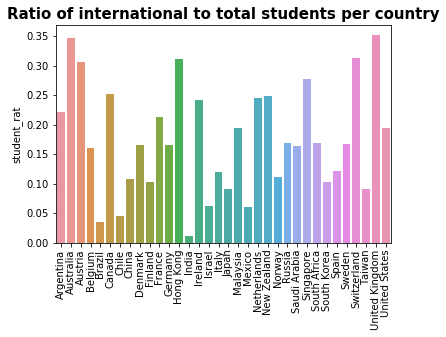

In [33]:
bar_plot(ranking_tu_by_country, 'Ratio of international to total students per country', 'student_rat', rotation=90)

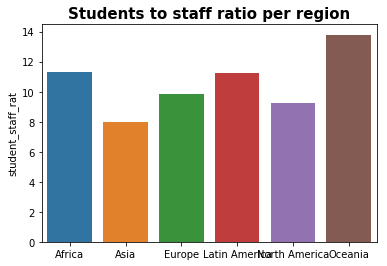

In [34]:
bar_plot(ranking_tu_by_region, 'Students to staff ratio per region', 'student_staff_rat')

---------------------

We will restart what we have done for the other ranking

In [35]:
the_r = requests.get(the_base_URL + the_rank_URL)

In [36]:
type(the_r.json())

dict

In [37]:
the_json = the_r.json()
the_data = the_json['data'][:200]

Taking a peek at what the data looks like for each university. Here we can see that we already get the stats we want

In [38]:
the_data[0]

{'aliases': 'University of Oxford',
 'location': 'United Kingdom',
 'member_level': '0',
 'name': 'University of Oxford',
 'nid': 468,
 'rank': '1',
 'rank_order': '10',
 'record_type': 'master_account',
 'scores_citations': '99.1',
 'scores_citations_rank': '15',
 'scores_industry_income': '63.7',
 'scores_industry_income_rank': '169',
 'scores_international_outlook': '95.0',
 'scores_international_outlook_rank': '24',
 'scores_overall': '94.3',
 'scores_overall_rank': '10',
 'scores_research': '99.5',
 'scores_research_rank': '1',
 'scores_teaching': '86.7',
 'scores_teaching_rank': '5',
 'stats_female_male_ratio': '46 : 54',
 'stats_number_students': '20,409',
 'stats_pc_intl_students': '38%',
 'stats_student_staff_ratio': '11.2',
 'subjects_offered': 'Archaeology,Art, Performing Arts & Design,Biological Sciences,Business & Management,Chemical Engineering,Chemistry,Civil Engineering,Computer Science,Economics & Econometrics,Electrical & Electronic Engineering,General Engineering,Geo

Keeping the data we need just as before, but we can get the stats directly now, so we no longer need the url

In [90]:
the_useful_data = []
for uni in the_data:
    the_useful_data.append({'name': uni['name'], 'rank': uni['rank'], 'country': uni['location'], 'student_tot': uni['stats_number_students'], 'student_staff_rat': float(uni['stats_student_staff_ratio']), 'student_rat': parse_int(uni['stats_pc_intl_students']) / 100})

Transforming the data into a nice `DataFrame`

In [91]:
ranking_the = pd.DataFrame(the_useful_data)
ranking_the['rank'] = ranking_the['rank'].map(parse_int)
ranking_the.head()

,country,name,rank,student_rat,student_staff_rat,student_tot
0,United Kingdom,University of Oxford,1,0.38,11.2,"20,409"
1,United Kingdom,University of Cambridge,2,0.35,10.9,"18,389"
2,United States,California Institute of Technology,3,0.27,6.5,"2,209"
3,United States,Stanford University,3,0.22,7.5,"15,845"
4,United States,Massachusetts Institute of Technology,5,0.34,8.7,"11,177"


Saving the `DataFrame` for later use

In [92]:
ranking_the.to_csv('timeshighereducation.csv', encoding='utf-8', index=False)

From the first ranking we generate a mapping from the country to the region that we applied to the second ranking

In [93]:
c = ranking_tu[['country','region']].drop_duplicates()
c = c.set_index("country")
map_country_region = c.T.to_dict(orient='records')[0]

#Handeling special case
map_country_region.update({"Luxembourg":"Europe","Russian Federation":"Europe"})

ranking_the["region"] = ranking_the["country"].map(map_country_region)
ranking_the.head()

,country,name,rank,student_rat,student_staff_rat,student_tot,region
0,United Kingdom,University of Oxford,1,0.38,11.2,"20,409",Europe
1,United Kingdom,University of Cambridge,2,0.35,10.9,"18,389",Europe
2,United States,California Institute of Technology,3,0.27,6.5,"2,209",North America
3,United States,Stanford University,3,0.22,7.5,"15,845",North America
4,United States,Massachusetts Institute of Technology,5,0.34,8.7,"11,177",North America


In [94]:
ranking_the_by_region = ranking_the.groupby(['region']).mean()
ranking_the_by_country = ranking_the.groupby(['country']).mean()

In [ ]:
bar_plot(ranking_tu_by_country, 'Ratio of international to total students per country', 'student_rat', rotation=90,sort=True)

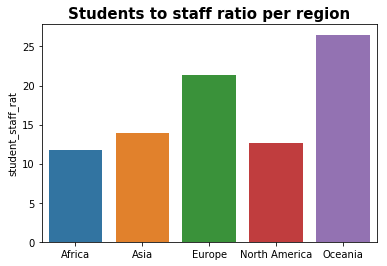

In [97]:
bar_plot(ranking_the_by_region, 'Students to staff ratio per region', 'student_staff_rat')

----------------------

In [43]:
import re

def keep_letters(s):
    return ''.join(c for c in s if c.isalpha())

def treat_special_cases(name):
    equiv = {
        'vrijeuniversiteitbrussel': 'universitélibredebruxelles',
        'universitédemontréal': 'universityofmontreal',
        'ecolepolytechnique': 'écolepolytechnique',
        'universitépierreetmariecurie': 'pierreandmariecurieuniversity',
        'ludwigmaximiliansuniversitätmünchen': 'lmumunich',
        'kitkarlsruheinstituteoftechnology': 'karlsruheinstituteoftechnology',
        'humboldtuniversitätzuberlin': 'humboldtuniversityofberlin',
        'freieuniversitaetberlin': 'freeuniversityofberlin',
        'technischeuniversitätberlin': 'technicaluniversityofberlin',
        'eberhardkarlsuniversitättübingen': 'universityoftübingen',
        'albertludwigsuniversitaetfreiburg': 'universityoffreiburg',
        'trinitycollegedublinuniversityofdublin': 'trinitycollegedublin',
        'scuolasuperioresantannapisadistudiuniversitariediperfezionamento': 'scuolasuperioresantanna',
        'wageningenuniversity': 'wageningenuniversityresearch',
        'kaistkoreaadvancedinstituteofsciencetechnology': 'koreaadvancedinstituteofscienceandtechnology',
        'universitatautònomadebarcelona': 'autonomousuniversityofbarcelona',
        'ethzurichswissfederalinstituteoftechnology': 'ethzurichswissfederalinstituteoftechnologyzurich',
        'ecolepolytechniquefédéraledelausanne': 'écolepolytechniquefédéraledelausanne',
        'ucl': 'universitycollegelondon',
        'universityofnorthcarolinachapelhill': 'universityofnorthcarolinaatchapelhill'
    }
    try:
        return equiv[name]
    except:
        return name

def norm_name(name):
    '''Sets the name to a standard for an easier matching'''
    name = name.lower() # Lowercase
    name = re.sub('(\().*?(\))', '', name) # Gets rid of things in brackets
    name = keep_letters(name) # Only keep alphas in string
    name = re.sub('the', '', name) # Deletes 'the' from the name 
    name = treat_special_cases(name) # Special cases we had to find by hand
    return name
    
norm_name('The Ecole - Polytéchnique (EPFL)')


'ecolepolytéchnique'

In [44]:
ranking_tu['norm_name'] = ranking_tu.name.map(norm_name)

In [45]:
ranking_tu

,country,name,rank,region,staff_int,staff_tot,student_int,student_tot,student_rat,student_staff_rat,norm_name
0,United States,Massachusetts Institute of Technology (MIT),1,North America,1679.0,2982.0,3717.0,11067.0,0.335863,3.711268,massachusettsinstituteoftechnology
1,United States,Stanford University,2,North America,2042.0,4285.0,3611.0,15878.0,0.227422,3.705484,stanforduniversity
2,United States,Harvard University,3,North America,1311.0,4350.0,5266.0,22429.0,0.234785,5.156092,harvarduniversity
3,United States,California Institute of Technology (Caltech),4,North America,350.0,953.0,647.0,2255.0,0.286918,2.366212,californiainstituteoftechnology
4,United Kingdom,University of Cambridge,5,Europe,2278.0,5490.0,6699.0,18770.0,0.356899,3.418944,universityofcambridge
5,United Kingdom,University of Oxford,6,Europe,2964.0,6750.0,7353.0,19720.0,0.372870,2.921481,universityofoxford
6,United Kingdom,UCL (University College London),7,Europe,2554.0,6345.0,14854.0,31080.0,0.477928,4.898345,universitycollegelondon
7,United Kingdom,Imperial College London,8,Europe,2071.0,3930.0,8746.0,16090.0,0.543567,4.094148,imperialcollegelondon
8,United States,University of Chicago,9,North America,635.0,2449.0,3379.0,13557.0,0.249244,5.535729,universityofchicago
9,Switzerland,ETH Zurich - Swiss Federal Institute of Techno...,10,Europe,1886.0,2477.0,7563.0,19815.0,0.381681,7.999596,ethzurichswissfederalinstituteoftechnologyzurich


In [46]:
ranking_the['norm_name'] = ranking_the.name.map(norm_name)

In [47]:
ranking_the.head()

,country,name,rank,student_rat,student_staff_rat,student_tot,region,norm_name
0,United Kingdom,University of Oxford,1,0.38,11.2,"20,409",Europe,universityofoxford
1,United Kingdom,University of Cambridge,2,0.35,10.9,"18,389",Europe,universityofcambridge
2,United States,California Institute of Technology,3,0.27,6.5,"2,209",North America,californiainstituteoftechnology
3,United States,Stanford University,3,0.22,7.5,"15,845",North America,stanforduniversity
4,United States,Massachusetts Institute of Technology,5,0.34,8.7,"11,177",North America,massachusettsinstituteoftechnology


In [57]:
ranking_merge_outer = pd.merge(ranking_tu, ranking_the, how='outer', on=['norm_name','region'], suffixes=('_tu', '_the'))[['country_tu', 'name_tu', 'norm_name', 'country_the', 'name_the']]

In [58]:
# Universtities that could not find any match
still_null = ranking_merge_outer[ranking_merge_outer.isnull().any(axis=1)]

still_null = still_null.sort_values(['country_tu', 'country_the'])
# still_null.to_excel('null.xls')

In [59]:
print('Number of schools that were not in both tables: {s}'.format(s=still_null.shape[0]))

Number of schools that were not in both tables: 80


In [61]:
ranking_merge = pd.merge(
    ranking_tu,
    ranking_the,
    how='outer',
    on=['norm_name', 'country', 'region'],
    suffixes=('_tu', '_the')
)[['norm_name',"name_tu", "name_the", 'country', 'region', 'rank_tu', 'rank_the']]

In [62]:
ranking_merge['rank_mean'] = ranking_merge[['rank_tu', 'rank_the']].mean(axis=1)
ranking_merge.sort_values('rank_mean')

,norm_name,name_tu,name_the,country,region,rank_tu,rank_the,rank_mean
1,stanforduniversity,Stanford University,Stanford University,United States,North America,2.0,3.0,2.5
0,massachusettsinstituteoftechnology,Massachusetts Institute of Technology (MIT),Massachusetts Institute of Technology,United States,North America,1.0,5.0,3.0
3,californiainstituteoftechnology,California Institute of Technology (Caltech),California Institute of Technology,United States,North America,4.0,3.0,3.5
4,universityofcambridge,University of Cambridge,University of Cambridge,United Kingdom,Europe,5.0,2.0,3.5
5,universityofoxford,University of Oxford,University of Oxford,United Kingdom,Europe,6.0,1.0,3.5
2,harvarduniversity,Harvard University,Harvard University,United States,North America,3.0,6.0,4.5
7,imperialcollegelondon,Imperial College London,Imperial College London,United Kingdom,Europe,8.0,8.0,8.0
8,universityofchicago,University of Chicago,University of Chicago,United States,North America,9.0,9.0,9.0
9,ethzurichswissfederalinstituteoftechnologyzurich,ETH Zurich - Swiss Federal Institute of Techno...,ETH Zurich – Swiss Federal Institute of Techno...,Switzerland,Europe,10.0,10.0,10.0
12,princetonuniversity,Princeton University,Princeton University,United States,North America,13.0,7.0,10.0


In [63]:
name_only_the = ranking_merge[ranking_merge["name_tu"].isnull()].set_index("norm_name")["name_the"]
name_only_tu = ranking_merge[ranking_merge["name_tu"].notnull()].set_index("norm_name")["name_tu"]

In [70]:
a = name_only_the.to_dict()
a.update(name_only_tu.to_dict())

In [79]:
final_ranking = ranking_merge.copy()
final_ranking['name'] = final_ranking["norm_name"].map(a)
final_ranking = final_ranking.drop(["norm_name", "name_tu","name_the"], axis=1).sort_values("rank_mean")

In [81]:
final_ranking.set_index("name")

,country,region,rank_tu,rank_the,rank_mean
name,,,,,
Stanford University,United States,North America,2.0,3.0,2.5
Massachusetts Institute of Technology (MIT),United States,North America,1.0,5.0,3.0
California Institute of Technology (Caltech),United States,North America,4.0,3.0,3.5
University of Cambridge,United Kingdom,Europe,5.0,2.0,3.5
University of Oxford,United Kingdom,Europe,6.0,1.0,3.5
Harvard University,United States,North America,3.0,6.0,4.5
Imperial College London,United Kingdom,Europe,8.0,8.0,8.0
University of Chicago,United States,North America,9.0,9.0,9.0
ETH Zurich - Swiss Federal Institute of Technology,Switzerland,Europe,10.0,10.0,10.0


### Finding Corellation

In [109]:
country_count_the = ranking_the.groupby("country")['name'].count().sort_values(ascending=False)
country_count_tu = ranking_tu.groupby("country")['name'].count().sort_values(ascending=False)